In [1]:
from dotenv import load_dotenv
load_dotenv()

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool

from langchain_core.tools import tool
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from typing import List

from IPython.display import Image, display
from typing_extensions import TypedDict

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
urls = [
    "https://www.rdstation.com/blog/marketing/marketing/",
    "https://www.rdstation.com/blog/vendas/vendas/",
    "https://langchain-ai.github.io/langgraph/tutorials/introduction/"
]

names = ["Marketing", "Vendas", "Ajuda"]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)

In [5]:
retrievers = {}
for doc,name in zip(docs_list, names):
    split = text_splitter.split_documents([doc])
    vectorstore = Chroma.from_documents(
        documents=split,
        collection_name=name,
        embedding=OpenAIEmbeddings(),
    )
    retriever_tool = create_retriever_tool(vectorstore.as_retriever(search_kwargs={"k": 3}), f"retrieve_{name}_posts", f"Ferramenta para buscar informações sobre {name}")
    retrievers.update({name:retriever_tool})

In [6]:
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

In [7]:
from langgraph.graph import END, StateGraph, START

class GraphState(TypedDict):
    question: str
    generation: str
    collection: str
    documents: List[str]

prompt = """
Você é um assistente com capacidade de realizar buscas para ajudar seus clientes que virão com dúvidas sobre algumas áreas distintas da empresa.

Para responder as dúvidas você tem um contexto personalizado:

{context}

Segue a pergunta do usuário:
"{question}"

"""

prompt = PromptTemplate.from_template(prompt)

rag_chain = prompt | llm | StrOutputParser()

class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    path: Literal["greet", "about", "contact", "question"] = Field(
        ...,
        description="Dada uma pergunta do usuário, você precisa decidir se é um cumprimento, se o usuário quer saber mais sobre você, se ele deseja informação de contato ou se é uma dúvida"
    )

structured_llm_router = llm.with_structured_output(RouteQuery)

system = """Você é um especialista em encaminhar um usuário para o local correto.
Existem quatro possibilidades:

Greet - quando a mensagem do usuário for apenas uma simples saudação.
About - quando o usuário deseja saber mais sobre você e suas capacidades.
Contact - quando o usuário deseja obter informações sobre como entrar em contato conosco.
Question - quando o usuário tem uma dúvida real sobre o conteúdo.
"""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

def route_question(state):
    print("-"*8)
    print("Começando roteamento")

    question = state["question"]
    source = question_router.invoke({"question": question})

    if source.path == "greet":
        print("Cumprimento")
        return "greet"
    elif source.path == "about":
        print("Sobre")
        return "about"
    elif source.path == "contact":
        print("Contato")
        return "contact"
    
    print("Pergunta")
    return "question"

class RouteRAG(BaseModel):

    path: Literal["Marketing", "Vendas", "Ajuda"] = Field(
        ...,
        description="Dada uma pergunta do usuário você precisa decidir o tópico da conversa entre Marketing, Vendas ou Ajuda"
    )

structured_llm_router = llm.with_structured_output(RouteRAG)

system = """Você precisa decidir o tópico da conversa entre três opções:
Marketing, Vendas ou Ajuda.
"""

RAG_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

RAG_router = RAG_prompt | structured_llm_router

def retrieve(state):
    question = state["question"]
    collection = RAG_router.invoke({"question": question}).path
    print(f"Realizando busca vetorial no banco de {collection}")
    
    documents = retrievers.get(collection).invoke(question)
    return {"documents": documents, "question": question}

def generate(state):
    print("Gerando resposta")
    print("-"*8)

    question = state["question"]
    documents = state["documents"]

    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def greet(state):
    print("Cumprimentando o usuário")
    print("-"*8)
    question = state["question"]
    message = "Olá, como você está?"
    return {"question": question, "generation": message}

def about(state):
    print("Devolvendo informações sobre o modelo")
    print("-"*8)
    question = state["question"]
    message = "Eu sou o assistente de apoio, posso te ajudar com dúvidas e dar informações sobre as áreas de Marketing, Vendas e Ajuda. O que você precisa hoje?"
    return {"question": question, "generation": message}

def contact(state):
    print("Devolvendo informações de contato")
    print("-"*8)
    question = state["question"]
    message = """Os nossos canais de atendimento são:
                    Pelo número: (12) 3456-7890
                    Pelo e-mail: atendimento@gmail.com
    """
    return {"question": question, "generation": message}

In [8]:
workflow = StateGraph(GraphState)
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate", generate)
workflow.add_node("greet", greet)
workflow.add_node("about", about)
workflow.add_node("contact", contact)
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "about": "about",
        "greet": "greet",
        "contact": "contact",
        "question": "retrieve"
    },
)
workflow.add_edge("retrieve", "generate")
workflow.add_edge("greet", END)
workflow.add_edge("about", END)
workflow.add_edge("contact", END)
workflow.add_edge("generate", END)
app = workflow.compile()

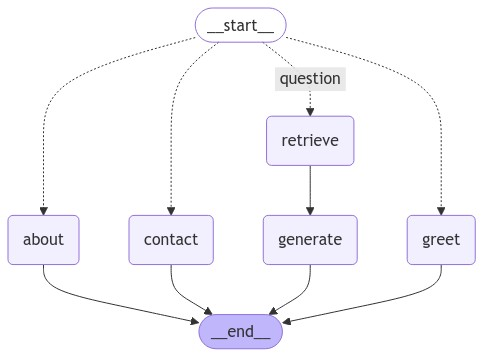

In [9]:
display(Image(app.get_graph().draw_mermaid_png()))

In [10]:
import pprint
from langchain_community.callbacks import get_openai_callback

In [11]:
def send_question(question):
    with get_openai_callback() as cb:
        result = app.invoke(input= {
            "question": question
        })
    print(result.get("generation"))
    print()
    print(cb)

In [12]:
send_question("Bom dia!")

--------
Começando roteamento
Comprimento
Cumprimentando o usuário
--------
Olá, como você está?

Tokens Used: 192
	Prompt Tokens: 186
	Completion Tokens: 6
Successful Requests: 1
Total Cost (USD): $3.15e-05


In [13]:
send_question("O que você pode fazer por mim?")

--------
Começando roteamento
Sobre
Devolvendo informações sobre o modelo
--------
Eu sou o assistente de apoio, posso te ajudar com dúvidas e dar informações sobre as áreas de Marketing, Vendas e Ajuda. O que você precisa hoje?

Tokens Used: 196
	Prompt Tokens: 191
	Completion Tokens: 5
Successful Requests: 1
Total Cost (USD): $3.165e-05


In [14]:
send_question("Preciso de um telefone para falar com alguém, pode me ajudar?")

--------
Começando roteamento
Contato
Devolvendo informações de contato
--------
Os nossos canais de atendimento são:
                    Pelo número: (12) 3456-7890
                    Pelo e-mail: atendimento@gmail.com
    

Tokens Used: 202
	Prompt Tokens: 197
	Completion Tokens: 5
Successful Requests: 1
Total Cost (USD): $3.255e-05


In [15]:
send_question("Como posso melhorar a performance das minhas campanhas publicitárias?")

--------
Começando roteamento
Pergunta
Realizando busca vetorial no banco de Marketing
Gerando resposta
--------
Para melhorar a performance das suas campanhas publicitárias, você pode seguir algumas estratégias eficazes:

1. **Segmentação de Público**: Utilize dados demográficos, comportamentais e de interesse para segmentar seu público-alvo de forma mais precisa. Isso permitirá que suas mensagens sejam mais relevantes e impactantes.

2. **Testes A/B**: Realize testes A/B com diferentes criativos, chamadas para ação (CTAs) e segmentações. Isso ajudará a identificar quais elementos funcionam melhor e a otimizar suas campanhas com base nos resultados.

3. **Otimização de Anúncios**: Analise o desempenho dos seus anúncios regularmente. Ajuste lances, palavras-chave e segmentações com base nas métricas de desempenho, como CTR (taxa de cliques) e conversões.

4. **Criatividade e Mensagem**: Invista em criativos atraentes e mensagens que ressoem com seu público. Utilize imagens de alta qual

In [16]:
send_question("Qual o modo correto de fazer uma oferta para um cliente?")

--------
Começando roteamento
Pergunta
Realizando busca vetorial no banco de Vendas
Gerando resposta
--------
Fazer uma oferta para um cliente de maneira eficaz envolve algumas etapas importantes. Aqui estão algumas dicas para garantir que sua oferta seja bem recebida:

1. **Entenda as Necessidades do Cliente**: Antes de fazer uma oferta, é fundamental entender as necessidades e desafios do cliente. Faça perguntas abertas para descobrir o que ele realmente precisa e quais problemas está enfrentando.

2. **Personalize a Oferta**: Com base nas informações coletadas, personalize sua oferta para que ela se alinhe diretamente às necessidades do cliente. Mostre como sua solução pode resolver os problemas específicos que ele mencionou.

3. **Destaque os Benefícios**: Em vez de apenas listar características do seu produto ou serviço, foque nos benefícios que o cliente obterá. Explique como sua solução pode melhorar a eficiência, reduzir custos ou aumentar a satisfação do cliente.

4. **Use Pro

In [17]:
send_question("O que a documentação diz sobre agentes?")

--------
Começando roteamento
Pergunta
Realizando busca vetorial no banco de Ajuda
Gerando resposta
--------
A documentação sobre agentes geralmente aborda os diferentes componentes e funções que eles desempenham. Aqui estão os principais componentes de um agente autônomo:

1. **Agente de Planejamento**: Este agente é responsável por determinar a estratégia geral e os passos necessários para alcançar um objetivo.

2. **Agente de Pesquisa**: Este componente coleta as informações necessárias para a execução das tarefas, garantindo que o agente tenha os dados relevantes.

3. **Agente de Revisão**: Avalia e refina o trabalho realizado, garantindo que a qualidade e a precisão das informações estejam em conformidade com os padrões desejados.

4. **Agente de Redação**: Produz o resultado final, seja um relatório, um artigo ou qualquer outro tipo de documento.

5. **Agente de Publicação**: Cuida da distribuição final ou aplicação dos resultados, garantindo que o produto final chegue ao público